In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import Lasso
import tensorflow as tf




df = pd.read_csv('menu_items.csv')
df2 = pd.read_csv("nutrition_data.csv")
df2.rename(columns={'item_id': 'id'}, inplace=True)
df = df.merge(df2, on="id", how="left")
df = df.sort_values(by='review_count', ascending=False).drop_duplicates(subset='id', keep='first')
df = df.sort_values(by='review_count', ascending=False).drop_duplicates(subset='name', keep='first')

C = df['rating'].mean()

# Step 2: Set minimum number of reviews required to be credible
m = 5  # You can adjust this based on your dataset

# Step 3: Compute the weighted rating
df['IMDB_rating'] = (
    (df['review_count'] / (df['review_count'] + m)) * df['rating'] +
    (m / (df['review_count'] + m)) * C
)
df = df[df["review_count"] >= 5]
df = df[df["calories"] >= 50]
relevant_columns = ["meat", "animal_products", "alcohol", 'coconut', 'dairy', 'egg', 'fish', 'gluten', 'peanuts', 'pork', 'sesame', 'shellfish', 'soy', 'tree_nut', 'wheat', "calories", "total_fat", "saturated_fat", "trans_fat", 'cholesterol', 'sodium', 'total_carbohydrate', 'dietary_fiber', 'total_sugars', "protein", "iron", "rating", "review_count", "IMDB_rating", "name", "course"]
df = df[relevant_columns]
df[df.select_dtypes(include=['bool']).columns] = df.select_dtypes(include=['bool']).astype(int)
df['total_fat'] = df['total_fat'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['saturated_fat'] = df['saturated_fat'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['trans_fat'] = df['trans_fat'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['cholesterol'] = df['cholesterol'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['sodium'] = df['sodium'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['total_carbohydrate'] = df['total_carbohydrate'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['dietary_fiber'] = df['dietary_fiber'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['total_sugars'] = df['total_sugars'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['protein'] = df['protein'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df['iron'] = df['iron'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

In [321]:
print(len(df))
print(len(df[df["rating"]==5]))
print(51/746)

746
51
0.06836461126005362


In [256]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=100)
train_X = train_df[["meat", "animal_products", "alcohol", 'coconut', 'dairy', 'egg', 'fish', 'gluten', 'peanuts', 'pork', 'sesame', 'shellfish', 'soy', 'tree_nut', 'wheat', "calories","total_fat", "saturated_fat", "trans_fat", 'cholesterol', 'sodium', 'total_carbohydrate', 'dietary_fiber', 'total_sugars', "protein", "iron"]]
train_y = train_df["IMDB_rating"]
test_X = test_df[["meat", "animal_products", "alcohol", 'coconut', 'dairy', 'egg', 'fish', 'gluten', 'peanuts', 'pork', 'sesame', 'shellfish', 'soy', 'tree_nut', 'wheat', "calories", "total_fat", "saturated_fat", "trans_fat", 'cholesterol', 'sodium', 'total_carbohydrate', 'dietary_fiber', 'total_sugars', "protein", "iron"]]
test_y = test_df["IMDB_rating"]
print(train_X.shape)
print(len(test_df))

(634, 26)
112


## Baseline

In [298]:
train_mean = train_y.mean()

y_hat = [train_mean] * len(test_y)
baseline_mse = mean_squared_error(y_hat, test_y)
print(baseline_mse)

0.5578801070121676


## OLS

In [299]:
train_X_const = sm.add_constant(train_X)

ols = sm.OLS(train_y, train_X_const).fit()
y_hat = ols.predict(sm.add_constant(test_X))
ols_mse = mean_squared_error(y_hat, test_y)
print(ols_mse)
print(ols.summary())

0.46623886986277047
                            OLS Regression Results                            
Dep. Variable:            IMDB_rating   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     6.513
Date:                Sun, 04 May 2025   Prob (F-statistic):           8.15e-20
Time:                        14:25:46   Log-Likelihood:                -598.52
No. Observations:                 634   AIC:                             1251.
Df Residuals:                     607   BIC:                             1371.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

## Lasso

In [300]:
lasso = Lasso(alpha=0.1)

lasso.fit(train_X, train_y)

y_hat = lasso.predict(train_X)

lasso_mse = mean_squared_error(train_y, y_hat)
print(lasso_mse)
non_zero_coef_idx = lasso.coef_ != 0
features_left = train_X.columns[non_zero_coef_idx]
print(features_left)
coef_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Coefficient': lasso.coef_
})
print(coef_df[['Feature', 'Coefficient']])


0.4234659529297833
Index(['calories', 'saturated_fat', 'cholesterol', 'sodium',
       'total_carbohydrate', 'dietary_fiber', 'total_sugars', 'protein',
       'iron'],
      dtype='object')
               Feature  Coefficient
0                 meat     0.000000
1      animal_products     0.000000
2              alcohol     0.000000
3              coconut    -0.000000
4                dairy     0.000000
5                  egg     0.000000
6                 fish     0.000000
7               gluten     0.000000
8              peanuts    -0.000000
9                 pork     0.000000
10              sesame     0.000000
11           shellfish    -0.000000
12                 soy     0.000000
13            tree_nut     0.000000
14               wheat     0.000000
15            calories    -0.000428
16           total_fat    -0.000000
17       saturated_fat     0.017624
18           trans_fat     0.000000
19         cholesterol     0.000860
20              sodium    -0.000142
21  total_carbohy

## NN

In [336]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Input(shape=(len(train_X.columns),)),
#   tf.keras.layers.Dense(64, activation='tanh'),
#   tf.keras.layers.Dropout(0.1),
#   tf.keras.layers.Dense(64, activation='tanh'),
#   tf.keras.layers.Dropout(0.1),
#   tf.keras.layers.Dense(32, activation='tanh'),
#   tf.keras.layers.Dense(1)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(len(train_X.columns),)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MSE
model.compile(optimizer="adam",
              loss=loss_fn,
              metrics=['MeanSquaredError'])
print(model.summary())

history = model.fit(
    train_X, train_y, 
    epochs=1000, 
    batch_size=32,)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_104 (Dense)               │ (None, 256)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,337 (1.03 MB)

 Trainable params: 270,337 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MeanSquaredError: 213.8029 - loss: 213.8029 
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 54.8460 - loss: 54.8460
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredError: 56.8503 - loss: 56.8503 
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MeanSquaredError: 26.8437 - loss: 26.8437
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanSquaredError: 22.9251 - loss: 22.9251
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 18.1132 - loss: 18.1132
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 15.4419 - loss: 15.4419
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 12.4388 - loss: 12.4388
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 10.4028 - loss: 10.4028
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 8.3734 - loss: 8.3734
Epoch 11/1000
20/20 ━━━━━━━━━━━━

In [335]:
y_hat = model.predict(test_X)
nn_mse = mean_squared_error(test_y, y_hat)
print(nn_mse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.5116413621076434


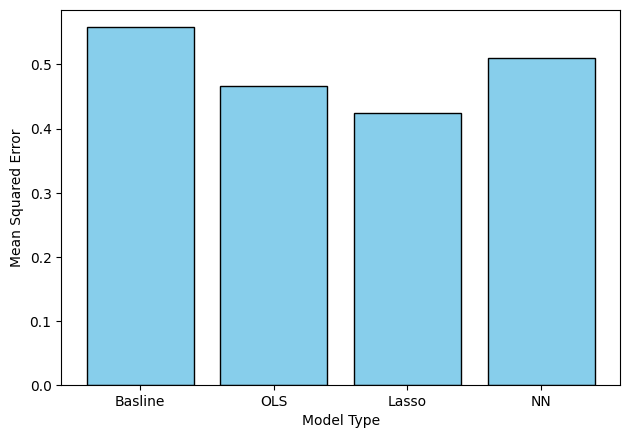

In [330]:
data = {'fruit': ['Basline', 'OLS', 'Lasso', "NN"],
        'color': [baseline_mse, ols_mse, lasso_mse, nn_mse]}
course_counts = pd.DataFrame(data)


plt.bar(course_counts['fruit'], course_counts['color'], color="skyblue", edgecolor="black")
plt.xlabel('Model Type')
plt.ylabel('Mean Squared Error')
#plt.title('Bar Graph of num by name')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels if names are long
plt.tight_layout()
plt.xticks(rotation=0)

plt.show()

## Data Exploration and Visualizations:

In [169]:
print(len(df))
max_calories_row = df.loc[df['calories'].idxmax()]
print(max_calories_row["calories"])

746
1960.0


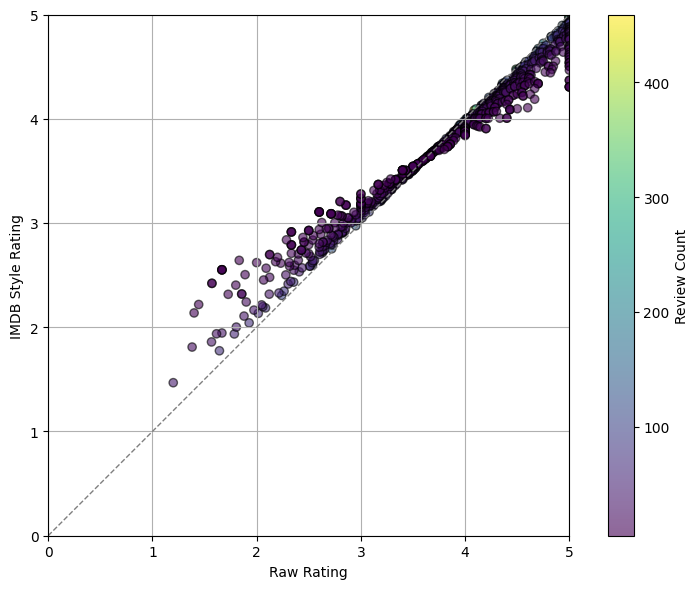

In [317]:
plt.figure(figsize=(8, 6))  
scatter = plt.scatter(
    df['rating'],
    df['IMDB_rating'],
    c=df['review_count'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='k'
)

plt.plot([0, 5.5], [0, 5.5], linestyle='--', color='gray', linewidth=1)

plt.xlabel('Raw Rating')
plt.ylabel('IMDB Style Rating')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.gca().set_aspect('equal')
#plt.title('Visualization of Rating to IMDB Style Rating Transformation')

cbar = plt.colorbar(scatter)
cbar.set_label('Review Count')

plt.grid(True)
plt.tight_layout()
plt.show()

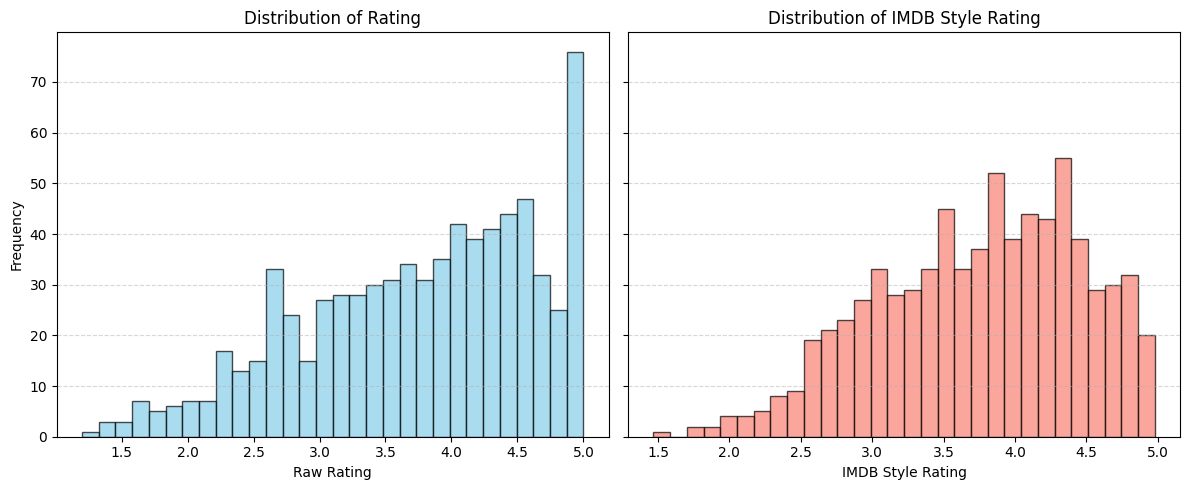

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(df['rating'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Rating')
axes[0].set_xlabel('Raw Rating')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

axes[1].hist(df['IMDB_rating'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of IMDB Style Rating')
axes[1].set_xlabel('IMDB Style Rating')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [173]:
top_10 = (
    df              # filter items with 10+ reviews
    .sort_values(by='IMDB_rating', ascending=False)  # sort by rating descending
    .head(10)                                   # get top 10
)
print(top_10[['name', 'IMDB_rating', 'rating', 'review_count']])

                                           name  IMDB_rating  rating  \
32965              Yale Breaded Chicken Tenders     4.980556   5.000   
39220                              Garlic Bread     4.973904   5.000   
11777  Food Truck-Style Grilled Cheese Sandwich     4.973552   4.994   
39364       Lemon and Panko Fried Chicken Katsu     4.945769   5.000   
3236                          Homemade Brownies     4.940159   5.000   
39619                      Raspberry Cheesecake     4.934514   5.000   
24845                   Shoestring French Fries     4.930585   5.000   
28434                      Chocolate Croissants     4.930585   5.000   
39840                               Spiced Naan     4.929168   5.000   
31041                        Chicken Quesadilla     4.922436   4.990   

       review_count  
32965           352  
39220           261  
11777           333  
39364           123  
3236            111  
39619           101  
24845            95  
28434            95  
39840    

In [174]:
top_10 = (
    df              
    .sort_values(by='IMDB_rating', ascending=True) 
    .head(10)                                
)
print(top_10[['name', 'IMDB_rating', 'rating', 'review_count']])

                                          name  IMDB_rating  rating  \
21535             Escarole and White Bean Bake     1.467966   1.200   
20690                           Creamy Polenta     1.774246   1.643   
28338  Acorn Squash with Crunchy Tofu Stuffing     1.809980   1.381   
36031               Okra and Mushroom Etouffee     1.859100   1.567   
29976                    Golden Shepherd's Pie     1.935647   1.786   
29396                   Beef Chuck "Pizzaiola"     1.937048   1.615   
29246                        Tuscan Bean Puree     1.944814   1.667   
22858                      Chili Verde Gardein     2.001380   1.805   
27657              Chef Stu's Matzoh Ball Soup     2.041763   1.928   
22935           Spicy Creole Eggplant Sandwich     2.106986   1.879   

       review_count  
21535            40  
20690            70  
28338            21  
36031            30  
29976            56  
29396            26  
29246            30  
22858            41  
27657            69 

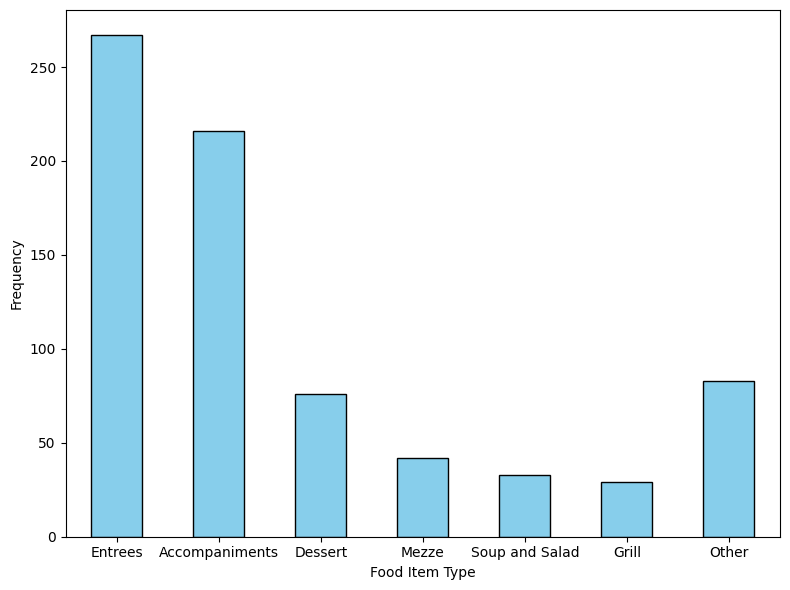

In [318]:
course_counts = df['course'].value_counts()

top_courses = course_counts.head(6)
other_courses = course_counts.iloc[6:].sum()


course_counts = pd.concat([top_courses, pd.Series({'Other': other_courses})])

plt.figure(figsize=(8, 6))
course_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xticks(rotation=0)

plt.xlabel('Food Item Type')
plt.ylabel('Frequency')
#plt.title('Bar Graph of Food Item Type Frequency')

plt.tight_layout()
plt.show()

In [ ]:
top_10 = (
    df             
    .sort_values(by='IMDB_rating', ascending=True)  
    .head(10)                                  
)
print(top_10[['name', 'IMDB_rating', 'rating', 'review_count']])

In [182]:
print(df.columns)
print(df['course'].value_counts(dropna=False))

Index(['meat', 'animal_products', 'alcohol', 'coconut', 'dairy', 'egg', 'fish',
       'gluten', 'peanuts', 'pork', 'sesame', 'shellfish', 'soy', 'tree_nut',
       'wheat', 'calories', 'total_fat', 'saturated_fat', 'trans_fat',
       'cholesterol', 'sodium', 'total_carbohydrate', 'dietary_fiber',
       'total_sugars', 'protein', 'iron', 'potassium', 'rating',
       'review_count', 'IMDB_rating', 'name', 'course'],
      dtype='object')
course
Entrees              267
Accompaniments       216
Dessert               76
Mezze                 42
Soup and Salad        33
Grill                 29
Salad Bar             23
Morning Sweets        15
Pasta Bar             14
Fruit and Yogurt       7
Breakfast Protein      6
Featured Items         5
Cereals                3
Smart Meals            3
Allergy Friendly       3
Special Event          3
Miscellaneous          1
Name: count, dtype: int64


In [98]:
print(len(df[df['review_count'] >= 5]))

820


In [100]:
top_10 = (
    df[df['rating'] == 5]            
    .sort_values(by='protein', ascending=False)  
    .head(10)                                  
print(top_10[['name', 'review_count']])

                                      name  review_count
32965         Yale Breaded Chicken Tenders           352
39220                         Garlic Bread           261
39364  Lemon and Panko Fried Chicken Katsu           123
3236                     Homemade Brownies           111
39619                 Raspberry Cheesecake           101
24845              Shoestring French Fries            95
28434                 Chocolate Croissants            95
39840                          Spiced Naan            93
24916                   Overnight Oats Bar            83
39352        Plantspired Beef Burrito Bowl            81


In [142]:
top_10 = (
    df             
    .sort_values(by='calories', ascending=True)  
    .head(20)                               
)
print(top_10[['name', 'calories', 'review_count']])

                                          name  calories  review_count
20121              Chef's Selection of the Day       0.0            10
23404                             Spring Water       0.0             6
587                              Spanish Onion       0.0            27
35758             Kettle Sea Salt Potato Chips       0.0             6
35648               Fresh Vegetable of the Day       0.0            26
1998                          Chef Choice Soup       0.0           133
1873                    Chefs Choice Vegetable       0.0            12
27479                 Chef's Choice Vegetables       0.0            15
588                                   Tomatoes       0.0            50
19262                         Shredded Lettuce       0.0            14
2735                            Fresh Cilantro       0.0             5
19261                           Diced Tomatoes       0.0            14
2023                                   Ketchup       5.0            61
1585  

In [106]:
top_10 = (
    df           
    .sort_values(by='IMDB_rating', ascending=False)  
    .head(25)                                 
)
print(top_10[['name', 'IMDB_rating', 'rating', 'review_count']])


                                                  name  IMDB_rating  rating  \
32965                     Yale Breaded Chicken Tenders     4.980556   5.000   
39220                                     Garlic Bread     4.973904   5.000   
11777         Food Truck-Style Grilled Cheese Sandwich     4.973552   4.994   
39364              Lemon and Panko Fried Chicken Katsu     4.945769   5.000   
3236                                 Homemade Brownies     4.940159   5.000   
39619                             Raspberry Cheesecake     4.934514   5.000   
24845                          Shoestring French Fries     4.930585   5.000   
28434                             Chocolate Croissants     4.930585   5.000   
39840                                      Spiced Naan     4.929168   5.000   
31041                               Chicken Quesadilla     4.922436   4.990   
24916                               Overnight Oats Bar     4.921119   5.000   
39352                    Plantspired Beef Burrito Bo

In [108]:
top_10 = (
    df             
    .sort_values(by='IMDB_rating', ascending=True) 
    .head(10)                              
)
print(top_10[['name', 'IMDB_rating', 'rating', 'review_count']])

                                                 name  IMDB_rating  rating  \
21535                    Escarole and White Bean Bake     1.467966   1.200   
20690                                  Creamy Polenta     1.774246   1.643   
28338         Acorn Squash with Crunchy Tofu Stuffing     1.809980   1.381   
36031                      Okra and Mushroom Etouffee     1.859100   1.567   
29976                           Golden Shepherd's Pie     1.935647   1.786   
29396                          Beef Chuck "Pizzaiola"     1.937048   1.615   
29246                               Tuscan Bean Puree     1.944814   1.667   
22858                             Chili Verde Gardein     2.001380   1.805   
27657                     Chef Stu's Matzoh Ball Soup     2.041763   1.928   
22935                  Spicy Creole Eggplant Sandwich     2.106986   1.879   
33520                        Sardinian Baked Eggplant     2.133331   2.016   
39804                          Coconut Tzatziki Sauce     2.1372